In [1]:
import torch
import torchvision
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import os




######################## configure device
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 1 is another GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


################## Set random seem for reproducibility
manualSeed = 9432
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
plt.ion()   # interactive mode
%matplotlib inline

cuda
Random Seed:  9432


The Steps for training a Neural Network are:

1. Load Data by creating a dataloader
2. Define the Network Model
3. Training the Network
4. Inference

1. Load Data : Dataloaders



In [2]:
# Define the transformations to be used for Data Augmentagtion, 
apply_transform = transforms.Compose([transforms.Resize(28),transforms.ToTensor()])

torchvision.transforms operate on PIL images. In general, additiona Data Augementation methods are applied only to the training set and not the validation/test sets.

See the following commonly used transforms in : https://pytorch.org/docs/stable/torchvision/transforms.html

Normalize(mean, std), RandomHorizontalFlip(),RandomVerticalFlip(), RandomResizedCrop(), ColorJitter(), RandomAffine()

train_dataset = torchvision.datasets.MNIST(root=os.getcwd()+'/data/',
                                           train=True, 
                                           transform=apply_transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=os.getcwd()+'/data/',
                                          train=False, 
                                          transform=apply_transform,
                                          download=True)

In [3]:
# Create Dataset

class MNIST_train(Dataset):
    # customized dataset
    def __init__(self, img_path, csv_name, transforms):
                
        img_nm=[]
        lbl=[]
        # read the entire csv file and save image_name, lbls
        with open(csv_name) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                img_nm.append(row[0])
                lbl.append(int(float(row[1])))
                
        self.img_nm=img_nm
        self.lbl=lbl
        self.img_path=img_path # dir of images.
        self.transform=transforms
        
      
        
    def __getitem__(self, index):
        ############# Return the sample data,gt for the input index
        # read the input image, gt
        # Read image as PIL
        tmp_img = Image.open(self.img_path+self.img_nm[index])
        # apply transform
        if self.transform is not None:
            tmp_img = self.transform(tmp_img)
        
        # convert label to tensor
        tmp_lbl=self.lbl[index]
        
        tmp_lbl=torch.from_numpy(np.array(tmp_lbl))
        tmp_lbl=tmp_lbl.long()
         
        return (tmp_img, tmp_lbl)
        

    def __len__(self):
        # Compute total number of samples in the dataset and return
        return len(self.lbl)

In [4]:
train_dataset=MNIST_train(os.getcwd()+'/data/MNIST_cutsom_dataloader/Train/', os.getcwd()+'/data/MNIST_cutsom_dataloader/train_part.csv', apply_transform)

val_dataset=MNIST_train(os.getcwd()+'/data/MNIST_cutsom_dataloader/Train/', os.getcwd()+'/data/MNIST_cutsom_dataloader/val_part.csv', apply_transform)

test_dataset=MNIST_train(os.getcwd()+'/data/MNIST_cutsom_dataloader/Test/', os.getcwd()+'/data/MNIST_cutsom_dataloader/test.csv', apply_transform)

torch.Size([1, 28, 28])
tensor(0)


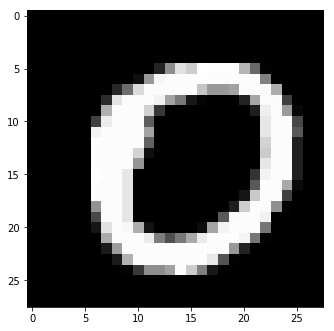

In [5]:
(f, lbl) = train_dataset[0]
print(f.shape)
print(lbl)

fig=plt.figure(figsize=(12, 12)) 
fig.add_subplot(2, 1, 1) 
f=f.numpy()
f=np.squeeze(f)
plt.imshow(f, cmap='gray', vmin=0, vmax=1)

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32, shuffle=False, num_workers=2)


val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=32, shuffle=False, num_workers=2)


2. Defining the Network Model

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, ftr_dim1, ftr_dim2, nclasses):
        super(NeuralNet, self).__init__()
        self.Layer1 = nn.Sequential(
            nn.Linear(28*28, ftr_dim1),
            nn.BatchNorm1d(num_features=ftr_dim1),
            nn.ReLU(),
            nn.Linear(ftr_dim1, ftr_dim2),
            nn.BatchNorm1d(num_features=ftr_dim2),
            nn.ReLU())
        
        self.classifier = nn.Sequential(
            nn.Linear(ftr_dim2, 10))

    def forward(self, x):
        x = x.view(x.shape[0],-1)# Flatten (batch_sz,1,28, 28) image to (batch_sz,28*28) 
        x = self.Layer1(x)
        x = self.classifier(x)
        return x

In [8]:
# create an instance of the model
model=NeuralNet(ftr_dim1=400, ftr_dim2=256, nclasses=10)
model=model.to(device) # Transfer the model from CPU to GPU
print(model) # Print the model architecture



# Count no of learnable parameters in the model
def count_parameters(model):
    # Returns only trainable params due to the last if
    # wouldnot work for shared parameters which will be counted multiple times
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print( "No. of learnable Network Parameters= "+str(count_parameters(model)))

NeuralNet(
  (Layer1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)
No. of learnable Network Parameters= 420538


In [9]:
def validate(val_loader, model, criterion):
    correct = 0 # Correctly predicted 
    total = 0 # Total number of samples
    running_loss=0
    
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            
            images = images.to(device) # put data into gpu
            labels = labels.to(device)
                    
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            # torch.max returns  a tuple (max_value, max_idx), the mx_idx gives the class label 
            predicted = torch.max(outputs, 1)[1] 
    
            # Compute Accuracy
            total += labels.size(0)
            correct += (predicted.detach() == labels).sum().item()

            running_loss=running_loss+loss.item() 
       
    
    
    
    
    acc=correct/total
    model.train()
    print ("\n Val_acc:  {:.4f}, Val_Classification Loss: {:.4f}"
                   .format(acc, running_loss/(i+1) ))
            
    return acc

In [10]:
# Obtain an instance of loss and optimizer 
criterion = nn.CrossEntropyLoss()

init_lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

In [11]:
############## TRAINING ###########
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
             
        

# Train the model
total_step = len(train_loader) # Number of batch updates in each epoch
curr_lr = init_lr
num_epochs=100 # maximum number of epochs for training

ptnc_cnt=0 # for Early stopping
patience=10 # Stop training if the val accuracy doesnot improve for "patience" epochs
max_metric=0 # best val accuracy encountered so far

for epoch in range(num_epochs):
    
    running_loss=0 # approximates the training loss by computing running average
    model.train() # Certain layers (for eg., BatchNorm and Dropout have different behaviours during training and inference)
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) # put data into gpu
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        
        
        # Backpropagation
        optimizer.zero_grad() #  remove previous gradients accumulated in optmizer
        loss.backward() # automatic gradient computation for each learnable parameter
        optimizer.step() # Update the learnable parameters
        
        
        # Display Training Loss after every 25 batch of updates for current epoch
        running_loss=running_loss+loss.item()
        if (i+1) % 25 == 0:
            print ("Epoch [{}/{}], Batch [{}/{}] Train Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss/(i+1)), end ="\r")
            
            
    ######### End of An Epoch ##################
    
    # Decay learning rate
    if (epoch+1) % 50 == 0:
        curr_lr /= 10
        update_lr(optimizer, curr_lr)
        
    # Monitor validation Loss
    metric=validate(val_loader, model, criterion)
    
    # Checkpoint and Early Stopping 
    if metric>max_metric:
        nm='best_weight_FC.pt'
        print("Val Performance improved, Saving checkpoint.. in "+nm)
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, nm)
        ptnc_cnt=0
        max_metric=metric
            
    else:
        ptnc_cnt=ptnc_cnt+1
        print('Validation metric has not improved in last '+str(ptnc_cnt)+' batch updates')
        if ptnc_cnt==patience:
            print("Early Stopping !")
            break
    

Epoch [1/100], Batch [1500/1500] Train Loss: 0.2483
 Val_acc:  0.9616, Val_Classification Loss: 0.1330
Val Performance improved, Saving checkpoint.. in best_weight_FC.pt
Epoch [2/100], Batch [1500/1500] Train Loss: 0.1312
 Val_acc:  0.9705, Val_Classification Loss: 0.0990
Val Performance improved, Saving checkpoint.. in best_weight_FC.pt
Epoch [3/100], Batch [1500/1500] Train Loss: 0.1040
 Val_acc:  0.9745, Val_Classification Loss: 0.0866
Val Performance improved, Saving checkpoint.. in best_weight_FC.pt
Epoch [4/100], Batch [1500/1500] Train Loss: 0.0879
 Val_acc:  0.9767, Val_Classification Loss: 0.0854
Val Performance improved, Saving checkpoint.. in best_weight_FC.pt
Epoch [5/100], Batch [1500/1500] Train Loss: 0.0742
 Val_acc:  0.9709, Val_Classification Loss: 0.1043
Validation metric has not improved in last 1 batch updates
Epoch [6/100], Batch [1500/1500] Train Loss: 0.0662
 Val_acc:  0.9758, Val_Classification Loss: 0.0872
Validation metric has not improved in last 2 batch upda

In [12]:
##### Training is complete, now load the best training weight from the checkpoint
checkpoint = torch.load('best_weight_FC.pt')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
del checkpoint

metric=validate(test_loader, model, criterion)


 Val_acc:  0.9809, Val_Classification Loss: 0.0951
